# Sphere Packing Assignment Sheet (Adv DL for Physics)

After importing phiflow, we setup a sufficiently large domain that can contain the spheres with no overlaps.
For this we choose a square domain of size $D=100.0$.

In [1]:
!pip install --quiet phiflow
from phi.torch.flow import *

math.set_global_precision(64)

In the following cell we select the domain size and radii as specified in the problem. We then construct tensors using the lists of type **Sphere** instance:

Domain size(D) = 100


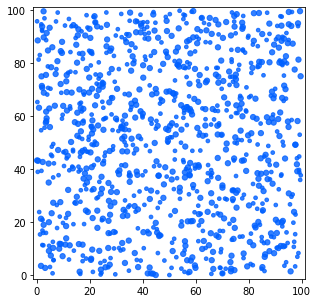

<Figure size 432x288 with 0 Axes>

In [2]:
D = 100 #Domain Size
seed = 0

r1 = 0.7
r2 = 1.0

Spheres_radii_list = []
Spheres_locations_list = []

for i in range(500):
    Spheres_radii_list.append(r1)
for i in range(500):
    Spheres_radii_list.append(r2)
    
math.seed(seed)

for i in range(1000):
    Spheres_locations_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_locations_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

## System Energy Function

The following cell contains our energy function responsible for imposing periodicity and computing energy as squares of the overlapping distance between the two circles *(or spheres)* and returns the total energy of the system. 
We clip all the spheres inside the domain and compute the net overlap energy considering the minimum distance between any two spheres. Here we note that the minimum distance between two spheres need not neccessarily lie inside the domain but even outside (in 8 possible other domains considering our 2D formulation).

**Note** : Since the gradient of sqrt function at zero is infinity we add a small perturbance $\epsilon$ to the zero entries of $dx$ tensor to avoid Nan values during backpropogation.

In [3]:
epsilon = 1e-10
def system_energy(x):
    
    #Since our domain is periodic particles must remain inside the domain
    x = x - math.floor(x/D) * D
    
    #Computing Position Vectors between every 2 spheres in the domain
    dx = x - math.rename_dims(x, 'spheres','others')
    
    #Adding epsilon value to prevent gradient of sqrt at zero at the diagonals of dx
    dx = dx + epsilon * math.ones_like(dx)
    
    #Since our domain is periodic, while computing minimum distance between any two spheres
    #we must consider their positions on all the possible directions in the 2D domain
    #for instance the nearest distance between two spheres at the left and right boundaries
    # doesn't span inside dx but rather around (other way) dx
    
    #dx_right, left, up, down, right_up, right_down, left_up and left down are the sphere 
    #position vectors shifted in the respective directions in order to compute minimum distance 
    #according to the periodic domain being used here
    dx_right = math.vec_squared(dx + tensor([1,0]) * math.ones_like(dx) * D) ** 0.5 
    dx_left = math.vec_squared(dx + tensor([-1,0]) * math.ones_like(dx) * D) ** 0.5
    
    dx_up = math.vec_squared(dx + tensor([0,1]) * math.ones_like(dx) * D) ** 0.5
    dx_down = math.vec_squared(dx + tensor([0,-1]) * math.ones_like(dx) * D) ** 0.5
    
    dx_right_up = math.vec_squared(dx + tensor([1,1]) * math.ones_like(dx) * D) ** 0.5
    dx_right_down = math.vec_squared(dx + tensor([1,-1]) * math.ones_like(dx) * D) ** 0.5
    
    dx_left_up = math.vec_squared(dx + tensor([-1,1]) * math.ones_like(dx) * D) ** 0.5
    dx_left_down = math.vec_squared(dx + tensor([-1,-1]) * math.ones_like(dx) * D) ** 0.5
    dist = math.min([math.vec_squared(dx) ** 0.5, dx_left, dx_right, dx_up, dx_down, 
                     dx_right_up, dx_right_down, dx_left_up, dx_left_down],dim='0')
    
    #Computing overlap between every two spheres in the domain
    E_system = math.maximum(radii + math.rename_dims(radii,'spheres','others') - dist,0)
    
    #dividing E_system by di using math.divide_no_nan ensures that spheres overlapping with themselves have 
    #zero energy
    #Multiplying E_system by itself to ensure that enrergy increases as the square of the overlapping distance
    #of spheres
    di = math.ones_like(dist) - tensor(np.eye(1000),instance('spheres','others'))
    
    E_system *= math.divide_no_nan(E_system,di)
    
    return math.sum(E_system)

## Loss Function

We then use **L2** loss for our system energy 

In [4]:
def loss_func(x):
    energy = system_energy(x)
    return math.l2_loss(energy - 0)
print(f'Initial System Energy: {system_energy(x)}')
print(f'Initial Loss of System : {loss_func(x):.4f}')

Initial System Energy: 433.4226685819998
Initial Loss of System : 93927.6048


## Gradient Descent Optimizer

We then define the gradient function from phi.math for gradient of our system energy loss and define our learning rate in order to learn our position tensor $x$ using gradient descent.

In [5]:
#Minimizing energy of system using gradient descent
gradient_function = math.functional_gradient(loss_func)

#Learning Rate may change depending on the domain size taken
#For smaller domains smaller lr needs to be chosen for faster convergence
#Also increasing learning rate during later stages shows faster convergence 
lr = 1e-3
for i in range(4000):
    loss, (grad,) = gradient_function(x)
    if (i+1)%200==0:
        print(f'iter={i+1}, loss={loss:.5f}')
    if (i+1==1000):
        lr = 1e-2
    if (i+1==3000):
        lr = 5e-2
    x = x - lr * grad

iter=200, loss=0.13796
iter=400, loss=0.04232
iter=600, loss=0.02093


KeyboardInterrupt: 

Visualizing the final results of our simulation: 

Domain size(D) = 100
System Energy = 0.0021
Loss: 2.2713675347835255e-06


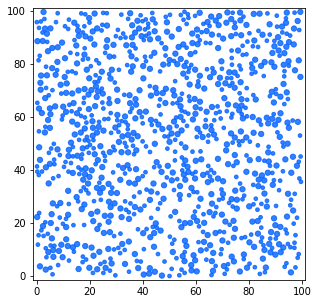

<Figure size 432x288 with 0 Axes>

In [170]:
#Visualizing Spheres after energy minimization
print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x):.4f}')
print(f'Loss: {loss_func(x)}')
x = x - math.floor(x/D) * D
vis.plot(Sphere(x, radius=radii * math.sqrt(2)), lib='matplotlib')

In [171]:
#Minimizing energy of system using higher order optimizer
#Here L-BFGS-B converges in 50 iterations as compared to 5000 iterations of gradient descent(with scheduling)
initial_locations = math.stack(Spheres_locations_list, instance('spheres'))
locations = math.minimize(system_energy, Solve('L-BFGS-B', 0, 1e-5,
max_iterations=50, x0=initial_locations))

Loss: 93927.60482037102
Domain size(D) = 100
System Energy = 0.0
Loss: 0.0


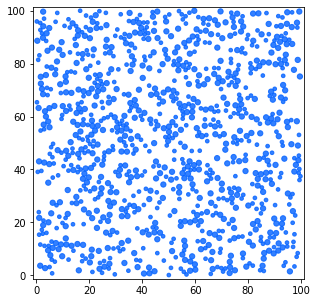

<Figure size 432x288 with 0 Axes>

In [172]:
print(f'Loss: {loss_func(initial_locations)}')
locations = locations - math.floor(locations/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(locations)}')
print(f'Loss: {loss_func(locations)}')
vis.plot(Sphere(locations, radius=radii * math.sqrt(2)), lib='matplotlib')

Domain size(D) = 53
System Energy = 1825.2632491704549
Loss: 1665792.964386143


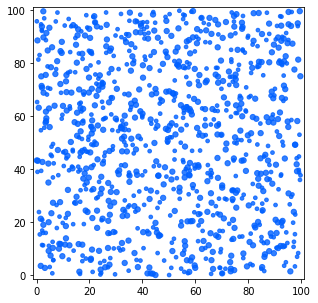

<Figure size 432x288 with 0 Axes>

In [173]:
#Trying for a domain size of D = 53
D = 53
seed += 1
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))
x1 = math.stack(Spheres_locations_list, instance('spheres'))


print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x1)}')
print(f'Loss: {loss_func(x1)}')
vis.plot(Sphere(x1, radius = radii * math.sqrt(2)), lib = 'matplotlib')

In [174]:
x1 = math.minimize(system_energy, Solve('L-BFGS-B', 0, 1e-5,
max_iterations=1000, x0=x1))

Domain size(D) = 53
System Energy = 0.0004466893345026074
Loss: 9.976568077919115e-08


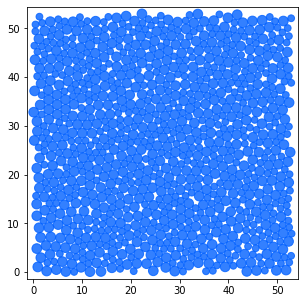

<Figure size 432x288 with 0 Axes>

In [175]:
print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x1)}')
print(f'Loss: {loss_func(x1)}')
x1 = x1 - math.floor(x1/D) * D
vis.plot(Sphere(x1, radius = radii*math.sqrt(2)), lib = 'matplotlib')
#vis.plot(PointCloud(Sphere(x1, radius=radii*math.sqrt(2)), bounds=Box(x=(-1, 54), y=(-1, 54))))

Domain size(D) = 52
System Energy = 109.72639974688971
Loss: 6019.941400707119


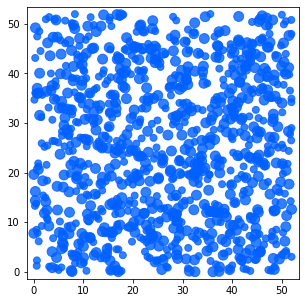

<Figure size 432x288 with 0 Axes>

In [176]:
#Trying for a domain size of D = 52
D = 52
seed += 1
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))
x2 = math.stack(Spheres_location_list, instance('spheres'))

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x1)}')
print(f'Loss: {loss_func(x1)}')
vis.plot(Sphere(x2, radius = radii * math.sqrt(2)), lib = 'matplotlib')

In [177]:
x2 = math.minimize(system_energy, Solve('L-BFGS-B', 0, 1e-5,
max_iterations=2000, x0=x2))

Domain size(D) = 52
System Energy = 1.583518232604416
Loss: 1.2537649964953066


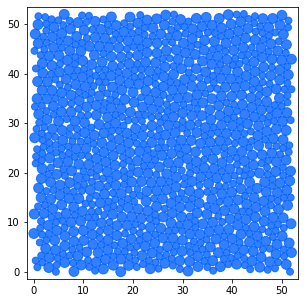

<Figure size 432x288 with 0 Axes>

In [178]:

x2 = x2 - math.floor(x2/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x2)}')
print(f'Loss: {loss_func(x2)}')
vis.plot(Sphere(x2, radius = radii*math.sqrt(2)), lib = 'matplotlib')

**Hence, for our initial problem, maximum domain size for which loss cannot be reduced to 0.01  anymore is 52!** (more precisely 52.4, above which the loss goes below 0.01 as can be seen from the analysis at the very end of the notebook)

# Case Study for Smallest Domain for multiple sphere sizes
Here we take radii in the interval $R \in (0,1]$ in steps of 0.1 and compute the smallest domain size for which the overlap energy $E$ is zero. 

For multiple radial configurations where the radii of second half of the spheres in the domain was varied in the interval $(0,1]$ we have found the below domain sizes where the loss reduced to below 0.01:

In [179]:
r1 = math.linspace(0.1,1.0,10)

Domain size(D) = 43.0


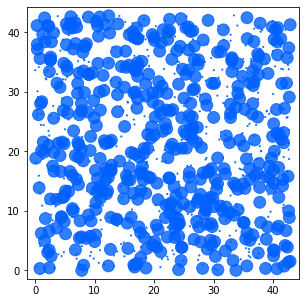

<Figure size 432x288 with 0 Axes>

In [180]:
D = 43.0
for i in range(500):
    Spheres_radii_list[i] = r1[0]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 43.0
System Energy = 0.004065122186442135
Loss: 8.262609195352043e-06


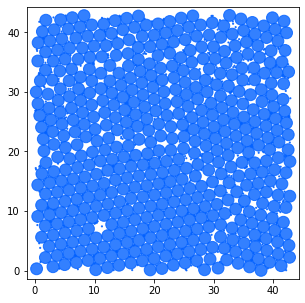

<Figure size 432x288 with 0 Axes>

In [181]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 44.0


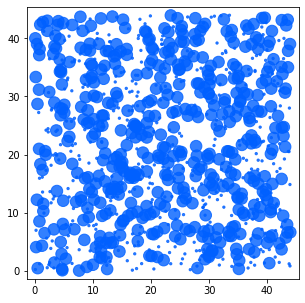

<Figure size 432x288 with 0 Axes>

In [182]:
D = 44.0
for i in range(500):
    Spheres_radii_list[i] = r1[1]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 44.0
System Energy = 0.00015483464386533612
Loss: 1.1986883470452734e-08


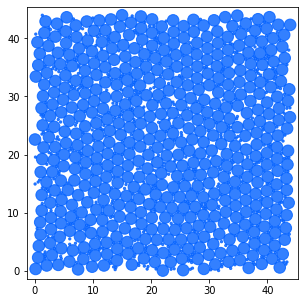

<Figure size 432x288 with 0 Axes>

In [183]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 45


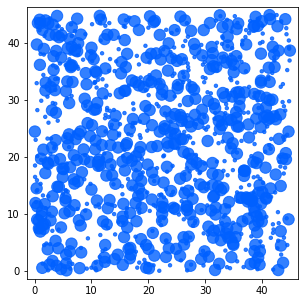

<Figure size 432x288 with 0 Axes>

In [184]:
D = 45
for i in range(500):
    Spheres_radii_list[i] = r1[2]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 45
System Energy = 0.0012332076353650302
Loss: 7.604005359613046e-07


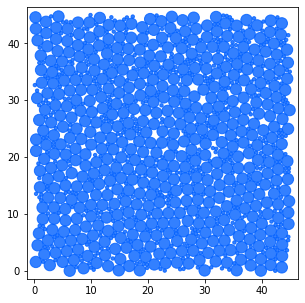

<Figure size 432x288 with 0 Axes>

In [185]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 46


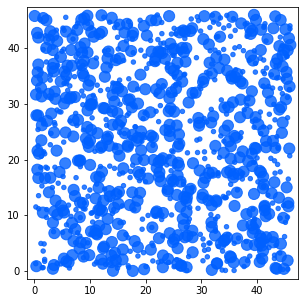

<Figure size 432x288 with 0 Axes>

In [186]:
D = 46
for i in range(500):
    Spheres_radii_list[i] = r1[3]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 46
System Energy = 0.18245099829999495
Loss: 0.01664418339033238


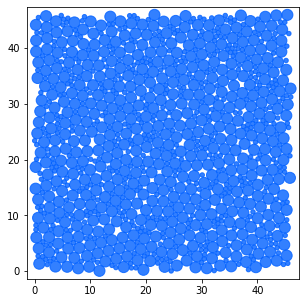

<Figure size 432x288 with 0 Axes>

In [187]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 48


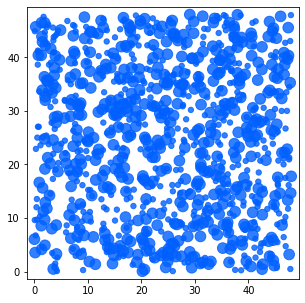

<Figure size 432x288 with 0 Axes>

In [188]:
D = 48
for i in range(500):
    Spheres_radii_list[i] = r1[4]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 48
System Energy = 0.09646146209024382
Loss: 0.004652406834293773


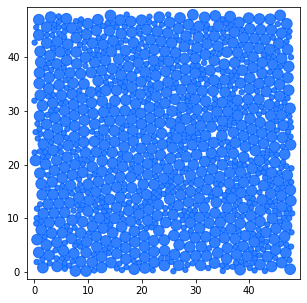

<Figure size 432x288 with 0 Axes>

In [189]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 50


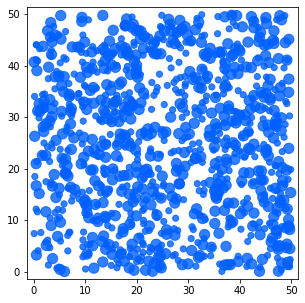

<Figure size 432x288 with 0 Axes>

In [190]:
D = 50
for i in range(500):
    Spheres_radii_list[i] = r1[5]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 50
System Energy = 0.2152218205604377
Loss: 0.023160216022674623


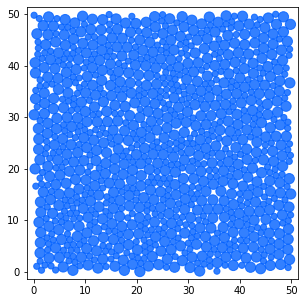

<Figure size 432x288 with 0 Axes>

In [191]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 56


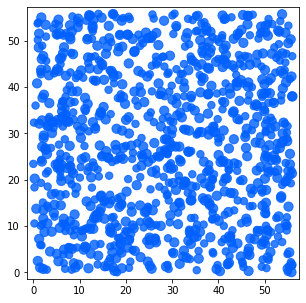

<Figure size 432x288 with 0 Axes>

In [192]:
D = 56
for i in range(500):
    Spheres_radii_list[i] = r1[7]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 56
System Energy = 0.00018178022381314682
Loss: 1.6522024884778874e-08


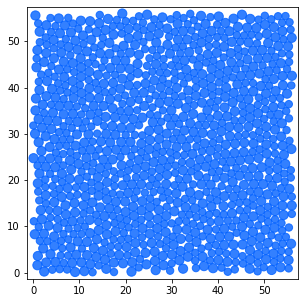

<Figure size 432x288 with 0 Axes>

In [193]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 59


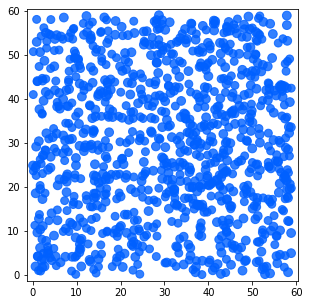

<Figure size 432x288 with 0 Axes>

In [194]:
D = 59
for i in range(500):
    Spheres_radii_list[i] = r1[8]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 59
System Energy = 4.020082537152952e-05
Loss: 8.080531802761058e-10


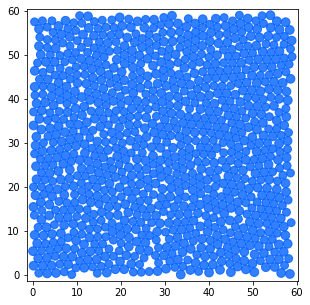

<Figure size 432x288 with 0 Axes>

In [195]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

Domain size(D) = 61


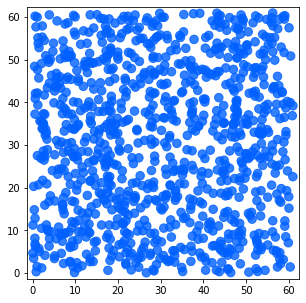

<Figure size 432x288 with 0 Axes>

In [196]:
D = 61
for i in range(500):
    Spheres_radii_list[i] = r1[9]

seed +=1
math.seed(seed)
Spheres_location_list = []
for i in range(1000):
    Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D))

x = math.stack(Spheres_location_list, instance('spheres'))
radii = math.stack(Spheres_radii_list, instance('spheres'))

print(f'Domain size(D) = {D}')
vis.plot(Sphere(x, radius=radii*math.sqrt(2)), lib='matplotlib')

Domain size(D) = 61
System Energy = 0.0009405591596443555
Loss: 4.423257663954481e-07


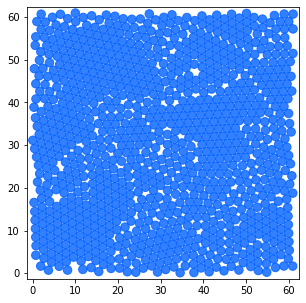

<Figure size 432x288 with 0 Axes>

In [197]:
x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=2000,x0=x))
x = x - math.floor(x/D) * D

print(f'Domain size(D) = {D}')
print(f'System Energy = {system_energy(x)}')
print(f'Loss: {loss_func(x)}')
vis.plot(Sphere(x, radius = radii*math.sqrt(2)), lib = 'matplotlib')

## Plot of Domain sizes against R for multiple initial random configurations
After gathering approximate domain sizes from the above simulations where we acheive a loss better than 0.01, for a better in-grained analysis we run it for multiple samples over a range of domain sizes.
The domain sizes for which we achieve a loss less than 0.01 are then stored in the *D_permissible* dictionary.

We then use the domain sizes present in this dictionary for multiple radii to compute their respective mean and std and for the error bar plot.

In [206]:
Spheres_radii_list = []
for i in range(1000):
    Spheres_radii_list.append(1.0)

R_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
D_dict = {0.1:42.0, 0.2:43.0, 0.3:44.0, 0.4:46.0, 0.5:48.0, 0.6:50.0, 0.7:52, 0.8:54, 0.9:58.0, 1.0:59.0}
D_freq = 0.2
num_freq = 11
D_permissible = {}
num_samples = 5
for r in R_list:
    D_permissible[r] = []
    for d in range(num_freq):
        D = D_dict[r] + d * D_freq
        net_loss = 0.0
        for sample in range(num_samples):
            # For every random configuration or sample 
            math.seed(sample)
            Spheres_location_list = []
            for i in range(500):
                Spheres_radii_list[i] = r
            for i in range(1000):
                Spheres_location_list.append( (math.random_uniform() * D, math.random_uniform() * D) )
            x = math.stack(Spheres_location_list, instance('spheres'))
            radii = math.stack(Spheres_radii_list, instance('spheres'))
            initial_loss = loss_func(x)
            x = math.minimize(system_energy, Solve('L-BFGS-B',0,1e-5,max_iterations=4000,x0=x))
            x = x - math.floor(x/D) * D
            final_loss = loss_func(x)
            net_loss += final_loss
            print(f'R : {r}, D : {D} , Sample : {sample}, Initial Loss : {initial_loss} , Final Loss : {final_loss}')
        avg_loss = net_loss/num_samples    
        if math.numpy(avg_loss) < 0.01 :
            D_permissible[r].append(D)

R : 0.1, D : 42.0 , Sample : 0, Initial Loss : 929359.458414798 , Final Loss : 2.1202097359179515
R : 0.1, D : 42.0 , Sample : 1, Initial Loss : 1007639.1098796002 , Final Loss : 0.5441870151567352
R : 0.1, D : 42.0 , Sample : 2, Initial Loss : 917777.6167608536 , Final Loss : 0.9495368661938658
R : 0.1, D : 42.0 , Sample : 3, Initial Loss : 1017234.0035254068 , Final Loss : 1.6931610314226748
R : 0.1, D : 42.0 , Sample : 4, Initial Loss : 1051858.8950608165 , Final Loss : 0.0006167444109499794
R : 0.1, D : 42.2 , Sample : 0, Initial Loss : 911736.8041423125 , Final Loss : 0.28394183625040614
R : 0.1, D : 42.2 , Sample : 1, Initial Loss : 988049.8171744354 , Final Loss : 0.2028246941795817
R : 0.1, D : 42.2 , Sample : 2, Initial Loss : 900405.6677490763 , Final Loss : 1.6345013632191503e-05
R : 0.1, D : 42.2 , Sample : 3, Initial Loss : 998783.0833347986 , Final Loss : 0.2080352457369446
R : 0.1, D : 42.2 , Sample : 4, Initial Loss : 1032192.5937659189 , Final Loss : 5.2289670876189e-0

R : 0.2, D : 44.0 , Sample : 1, Initial Loss : 951423.5034757007 , Final Loss : 1.1497381654126366e-07
R : 0.2, D : 44.0 , Sample : 2, Initial Loss : 869134.1005567353 , Final Loss : 3.6349944470635e-09
R : 0.2, D : 44.0 , Sample : 3, Initial Loss : 961061.2967062376 , Final Loss : 1.4772217554819422e-07
R : 0.2, D : 44.0 , Sample : 4, Initial Loss : 990841.9883906345 , Final Loss : 1.1986883470452734e-08
R : 0.2, D : 44.2 , Sample : 0, Initial Loss : 860802.2825442272 , Final Loss : 1.164721449044929e-09
R : 0.2, D : 44.2 , Sample : 1, Initial Loss : 933744.6042658722 , Final Loss : 4.526350633513464e-09
R : 0.2, D : 44.2 , Sample : 2, Initial Loss : 853454.5184289633 , Final Loss : 3.4621422678297066e-09
R : 0.2, D : 44.2 , Sample : 3, Initial Loss : 944368.9451889561 , Final Loss : 8.04643563552974e-10
R : 0.2, D : 44.2 , Sample : 4, Initial Loss : 973197.8241904038 , Final Loss : 1.3702711940426337e-09
R : 0.2, D : 44.4 , Sample : 0, Initial Loss : 845147.1267651689 , Final Loss : 

R : 0.3, D : 46.0 , Sample : 2, Initial Loss : 857454.9953297751 , Final Loss : 9.321194682478942e-11
R : 0.3, D : 46.0 , Sample : 3, Initial Loss : 943856.8949309315 , Final Loss : 6.671067778860444e-10
R : 0.3, D : 46.0 , Sample : 4, Initial Loss : 970569.754928266 , Final Loss : 1.2539705708766595e-10
R : 0.4, D : 46.0 , Sample : 0, Initial Loss : 1059588.5962899448 , Final Loss : 0.014213891332371881
R : 0.4, D : 46.0 , Sample : 1, Initial Loss : 1147477.5914607546 , Final Loss : 0.03604041246182985
R : 0.4, D : 46.0 , Sample : 2, Initial Loss : 1047339.9174329145 , Final Loss : 0.015266710750667387
R : 0.4, D : 46.0 , Sample : 3, Initial Loss : 1144257.5049528743 , Final Loss : 0.024465598092527113
R : 0.4, D : 46.0 , Sample : 4, Initial Loss : 1174554.9017471795 , Final Loss : 0.021347997562584577
R : 0.4, D : 46.2 , Sample : 0, Initial Loss : 1040914.0200941446 , Final Loss : 0.004126389335496416
R : 0.4, D : 46.2 , Sample : 1, Initial Loss : 1127175.8180065218 , Final Loss : 0.

R : 0.5, D : 48.8 , Sample : 2, Initial Loss : 1052342.3005519935 , Final Loss : 6.053618725565983e-10
R : 0.5, D : 48.8 , Sample : 3, Initial Loss : 1147326.3161152464 , Final Loss : 7.031503586108876e-10
R : 0.5, D : 48.8 , Sample : 4, Initial Loss : 1169573.0543586705 , Final Loss : 6.214332459418969e-10
R : 0.5, D : 49.0 , Sample : 0, Initial Loss : 1050860.9840779756 , Final Loss : 4.5572992610156254e-10
R : 0.5, D : 49.0 , Sample : 1, Initial Loss : 1128123.304124447 , Final Loss : 1.815448383162154e-10
R : 0.5, D : 49.0 , Sample : 2, Initial Loss : 1035504.7675305989 , Final Loss : 2.0487281885096598e-10
R : 0.5, D : 49.0 , Sample : 3, Initial Loss : 1129045.480631703 , Final Loss : 2.357425748332268e-10
R : 0.5, D : 49.0 , Sample : 4, Initial Loss : 1150806.979471898 , Final Loss : 3.4934210424973813e-09
R : 0.5, D : 49.2 , Sample : 0, Initial Loss : 1033422.9480947533 , Final Loss : 2.702544769958972e-10
R : 0.5, D : 49.2 , Sample : 1, Initial Loss : 1109403.1452599063 , Final

R : 0.6, D : 51.8 , Sample : 2, Initial Loss : 1099387.4803811002 , Final Loss : 1.6786818241084798e-10
R : 0.6, D : 51.8 , Sample : 3, Initial Loss : 1194554.9669619144 , Final Loss : 7.074121894487147e-11
R : 0.6, D : 51.8 , Sample : 4, Initial Loss : 1209108.1693979576 , Final Loss : 1.579867857163743e-10
R : 0.6, D : 52.0 , Sample : 0, Initial Loss : 1106036.7445197576 , Final Loss : 2.5501606258405323e-10
R : 0.6, D : 52.0 , Sample : 1, Initial Loss : 1172895.7824015436 , Final Loss : 4.850797329500976e-11
R : 0.6, D : 52.0 , Sample : 2, Initial Loss : 1082892.5361791544 , Final Loss : 5.6788609238675085e-11
R : 0.6, D : 52.0 , Sample : 3, Initial Loss : 1176536.94807886 , Final Loss : 7.323536897973692e-11
R : 0.6, D : 52.0 , Sample : 4, Initial Loss : 1190794.945336439 , Final Loss : 7.000742024837762e-11
R : 0.7, D : 52.0 , Sample : 0, Initial Loss : 1546611.4244358963 , Final Loss : 1.2753894649373905
R : 0.7, D : 52.0 , Sample : 1, Initial Loss : 1615846.0070045176 , Final Lo

R : 0.8, D : 54.6 , Sample : 3, Initial Loss : 1874692.3803652767 , Final Loss : 1.5706876411356123
R : 0.8, D : 54.6 , Sample : 4, Initial Loss : 1871842.2019609925 , Final Loss : 1.1700498650312836
R : 0.8, D : 54.8 , Sample : 0, Initial Loss : 1800513.4540758769 , Final Loss : 0.6244885394703255
R : 0.8, D : 54.8 , Sample : 1, Initial Loss : 1853370.1515935974 , Final Loss : 0.6317324522334242
R : 0.8, D : 54.8 , Sample : 2, Initial Loss : 1709152.2014888478 , Final Loss : 0.5462599189486248
R : 0.8, D : 54.8 , Sample : 3, Initial Loss : 1847788.3982533875 , Final Loss : 0.33197236261881863
R : 0.8, D : 54.8 , Sample : 4, Initial Loss : 1844932.8780422453 , Final Loss : 0.6841030505316591
R : 0.8, D : 55.0 , Sample : 0, Initial Loss : 1773852.779515458 , Final Loss : 0.1255667830872269
R : 0.8, D : 55.0 , Sample : 1, Initial Loss : 1826051.131960025 , Final Loss : 0.06857378577033874
R : 0.8, D : 55.0 , Sample : 2, Initial Loss : 1685086.2946367105 , Final Loss : 0.13798852610050155

R : 0.9, D : 59.6 , Sample : 3, Initial Loss : 1918286.1368684368 , Final Loss : 9.015738009113906e-11
R : 0.9, D : 59.6 , Sample : 4, Initial Loss : 1904772.4653653952 , Final Loss : 3.1804900121767924e-10
R : 0.9, D : 59.8 , Sample : 0, Initial Loss : 1861072.4366668523 , Final Loss : 3.2726906453984434e-11
R : 0.9, D : 59.8 , Sample : 1, Initial Loss : 1891343.1114879297 , Final Loss : 1.1340416551055603e-10
R : 0.9, D : 59.8 , Sample : 2, Initial Loss : 1763706.6944122675 , Final Loss : 5.4218509601067716e-11
R : 0.9, D : 59.8 , Sample : 3, Initial Loss : 1892875.0081806039 , Final Loss : 8.55817099705214e-11
R : 0.9, D : 59.8 , Sample : 4, Initial Loss : 1879590.8724889755 , Final Loss : 7.766913742909803e-11
R : 0.9, D : 60.0 , Sample : 0, Initial Loss : 1835682.9396427833 , Final Loss : 2.866822685681154e-11
R : 0.9, D : 60.0 , Sample : 1, Initial Loss : 1865916.0970321612 , Final Loss : 7.69636261027732e-11
R : 0.9, D : 60.0 , Sample : 2, Initial Loss : 1741105.3247807068 , Fin

In [207]:
D_permissible

{0.1: [42.8, 43.0, 43.2, 43.4, 43.6, 43.8, 44.0],
 0.2: [43.4, 43.6, 43.8, 44.0, 44.2, 44.4, 44.6, 44.8, 45.0],
 0.3: [44.6, 44.8, 45.0, 45.2, 45.4, 45.6, 45.8, 46.0],
 0.4: [46.2, 46.4, 46.6, 46.8, 47.0, 47.2, 47.4, 47.6, 47.8, 48.0],
 0.5: [48.0, 48.2, 48.4, 48.6, 48.8, 49.0, 49.2, 49.4, 49.6, 49.8, 50.0],
 0.6: [50.2, 50.4, 50.6, 50.8, 51.0, 51.2, 51.4, 51.6, 51.8, 52.0],
 0.7: [52.6, 52.8, 53.0, 53.2, 53.4, 53.6, 53.8, 54.0],
 0.8: [55.4, 55.6, 55.8, 56.0],
 0.9: [58.0, 58.2, 58.4, 58.6, 58.8, 59.0, 59.2, 59.4, 59.6, 59.8, 60.0],
 1.0: [59.8, 60.0, 60.2, 60.4, 60.6, 60.8, 61.0]}

### Error Bar Plot for Domain Sizes for Radii R, with standard deviations for multiple configurations



In [208]:
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

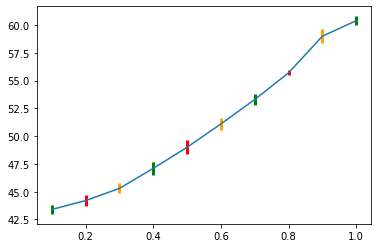

In [209]:
D_std = []
D_mean = []
for r in R_list:
    D_mean.append(np.mean(D_permissible[r]))
    D_std.append(np.std(D_permissible[r]))
plt.errorbar(R_list, D_mean, yerr = D_std, ecolor=['green','red','orange'],elinewidth=3)